# Brain Training
This is the first notebook where everything regarding NF Training will come together

## 1. Preparation I: modules and where to put files
- double check all these parameters
- change sub and sess according to the current participant and session (!)
- double check the destination directory to be sure
- don't use the Template Notebook (if you do so...), but copy/paste a notebook into a subject/session specific directory!
- do not do this work just before a measurement. Have it prepared (and preferable tested!)

In [1]:
# import (most of the) modules that we need
import time
import re
import os
from multiprocessing import Process
from datetime import datetime
import numpy as np
import pylsl
from nftools import guis
from nftools.nftools import no_bad_samples, no_bad_channels, detect_channel_types
import mne
import dynarray
import pickle
from scipy import io as spio

In [2]:
# use the qt event loop, disable warnings (they flood the screen)
%matplotlib qt  
# %gui qt

import warnings; warnings.filterwarnings('ignore') 
mne.set_config('MNE_LOGGING_LEVEL', 'WARNING')

## 2. Define sub, session and run numbers
- this will also load all the available data - if they've already been recorded!

In [3]:
# change these according to which sub-sess we have:
sub = 4
sess = 1
run = 2

In [4]:
# define where we put our stuff - prepare for BIDS Format Style
save_dir = '/home/johan/nf/rawdata/BrainTraining/bids'
this_save_dir = os.path.join(save_dir, 'sub-{:02d}'.format(sub), 'sess-{:02d}'.format(sess), 'eeg')

# we should also ... MAKE this savedir! If it exists, we don't do anything.
if not os.path.exists(this_save_dir):
    os.makedirs(this_save_dir)
    print("Directory " , this_save_dir ,  " Created ")
else:    
    print("Directory " , this_save_dir ,  " already exists")   
    
    
# expected files to be read/written:
fname_raw_eo_run = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'eo', run))
fname_raw_ec_run = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'ec', run))
fname_ica_ocular_rejection = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_ica-ocular-rejection_run-{:02d}.pkl'.format(sub, sess, run))
fname_csp_alpha_rejection = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_csp-alpha-rejection_run-{:02d}.pkl'.format(sub, sess, run))

fname_calibration_envelopes = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_calibration_envelopes_run-{:02d}.pkl'.format(sub, sess, run))
fname_calibration_parameters = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_calibration_parameters_run-{:02d}.pkl'.format(sub, sess, run))

fname_raw_nftraining_run = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'raw-nftraining', run))
fname_rtanalyzed_nftraining_eeg = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'rtanalyzed-nftraining-eeg', run))
fname_rtanalyzed_nftraining_emg = os.path.join(this_save_dir, 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'rtanalyzed-nftraining-emg', run))



# if files exist, load them
if os.path.exists(fname_raw_eo_run):
    print('found raw eyes open: \t\t' + os.path.basename(fname_raw_eo_run))
    raw_eo = mne.io.read_raw_fif(fname_raw_eo_run, preload=True)
if os.path.exists(fname_raw_ec_run):
    print('found raw eyes closed: \t\t' + os.path.basename(fname_raw_ec_run))
    raw_ec = mne.io.read_raw_fif(fname_raw_ec_run, preload=True)
if os.path.exists(fname_ica_ocular_rejection):
    print('found ica eyeblink rejection:\t' + os.path.basename(fname_ica_ocular_rejection))
    with open(fname_ica_ocular_rejection,'rb') as f:
        ica_rejection = pickle.load(f)
if os.path.exists(fname_csp_alpha_rejection):
    print('found csp alpha rejection: \t' + os.path.basename(fname_csp_alpha_rejection))
    with open(fname_csp_alpha_rejection, 'rb') as f:
        csp_rejection = pickle.load(f)

if os.path.exists(fname_calibration_envelopes):
    print('found calibration envelopes: \t' + os.path.basename(fname_calibration_envelopes))
    with open(fname_calibration_envelopes, 'rb') as f: 
        calibration_envelopes = pickle.load(f)
    locals().update(calibration_envelopes)
if os.path.exists(fname_calibration_parameters):
    print('found calibration parameters: \t' + os.path.basename(fname_calibration_parameters))
    with open(fname_calibration_parameters, 'rb') as f: 
        calibration_parameters = pickle.load(f)
    locals().update(calibration_parameters)
        
if os.path.exists(fname_raw_nftraining_run):
    print('found raw nftraining: \t\t' + os.path.basename(fname_raw_nftraining_run))
    raw_nftraining = mne.io.read_raw_fif(fname_raw_nftraining_run)
if os.path.exists(fname_rtanalyzed_nftraining_eeg):
    print('found rt-analyzed eeg: \t\t' + os.path.basename(fname_rtanalyzed_nftraining_eeg))
    rtanalyzed_nftraining_eeg = mne.io.read_raw_fif(fname_rtanalyzed_nftraining_eeg)
if os.path.exists(fname_rtanalyzed_nftraining_emg):
    print('found rt-analyzed emg: \t\t' + os.path.basename(fname_rtanalyzed_nftraining_emg))
    rtanalyzed_nftraining_emg = mne.io.read_raw_fif(fname_rtanalyzed_nftraining_emg)        

Directory  /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg  already exists
found raw eyes open: 		sub-04_sess-01_task-eo_run-02.fif
found raw eyes closed: 		sub-04_sess-01_task-ec_run-02.fif
found ica eyeblink rejection:	sub-04_sess-01_ica-ocular-rejection_run-02.pkl
found csp alpha rejection: 	sub-04_sess-01_csp-alpha-rejection_run-02.pkl
found calibration envelopes: 	sub-04_sess-01_calibration_envelopes_run-02.pkl
found calibration parameters: 	sub-04_sess-01_calibration_parameters_run-02.pkl
found raw nftraining: 		sub-04_sess-01_task-raw-nftraining_run-02.fif
found rt-analyzed eeg: 		sub-04_sess-01_task-rtanalyzed-nftraining-eeg_run-02.fif
found rt-analyzed emg: 		sub-04_sess-01_task-rtanalyzed-nftraining-emg_run-02.fif


## 3. Preparion, II: Fix/check the EEG Cap

- fix the EEG Cap
- check with openBCI GUI if the signals look OK, once they do:
- run the `python raw_eo_data --stream`, followed by `/start`
- the light on the usb stick should go <font color="red">RED</font>
- (re)-start the Cap or USB if it doesn't work, followed by commands above

## 4. Connect to the real-time Data Stream

In [5]:
# prints out which streams are currently available
stream_ids = [ pylsl.stream_inlet(s).info().source_id() for s in pylsl.resolve_streams() ]
print(stream_ids)

['someidentifier123']


- copy/paste the eeg lab name (left of the 2 outputs) into stream_id variable:
- thake the one that says **eeg**, not aux!

In [6]:
# 'subscribe' to a data stream; grab all essential(s), fs, names, etc
# stream_id = 'openbci_eeg_id134'

# eeg_stream_id = [stream_id for stream_id in stream_ids if re.match('.*_eeg_.*', stream_id)]
eeg_stream_id = [stream_id for stream_id in stream_ids if re.match('.*some.*', stream_id)]
if len(eeg_stream_id)>0:
    eeg_stream_id=eeg_stream_id[0]
print(eeg_stream_id)

someidentifier123


In [7]:
# try grabbing all the information from that stream:
data_stream=pylsl.resolve_byprop("source_id", eeg_stream_id, timeout=5.0)
if data_stream:
    data_inlet=pylsl.stream_inlet(data_stream[0], max_buflen=10)
    stream_info = data_inlet.info()
    stream_Fs = stream_info.nominal_srate()
    stream_xml = stream_info.desc()
    chans_xml = stream_xml.child("channels")
    chan_xml_list = []
    ch = chans_xml.child("channel")
    while ch.name() == "channel":
        chan_xml_list.append(ch)
        ch = ch.next_sibling("channel")
    channel_names = [ch_xml.child_value("label") for ch_xml in chan_xml_list]
    data_inlet_dt = data_inlet.time_correction(timeout=5.0)
    sampling_freq = data_stream[0].nominal_srate()
    print('name = %s' % data_stream[0].name())
    print('sampling_freq = %d' % sampling_freq)
    print('channel_count = %d' % data_stream[0].channel_count())
    print('channel_format = %d' % data_stream[0].channel_format())
else:
    raise Exception('No Data Stream Found - Is your EEG Cap running?')

name = Playback-3
sampling_freq = 500
channel_count = 32
channel_format = 1


## 5.1 Measure Some Data (Eye Open)
- Inform that the following measurement is an eye open measurement.
- Subjects are allowed to blink as normal
- duration about 2 minutes
- might have to re-run this in order to fix a channel from being busted
- when ready press 'stop acquisition' and close window

In [9]:
# we put the incoming data in here:
np_eo = dynarray.DynamicArray((None, len(channel_names)))

# init/open the window in which we visualize data
w=guis.AcquireData(sampling_freq, channel_names)

# before we start, pull everything from the buffer (empty it)
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 
    
# then start acquiring data as long as button 'stop' not pressed:
w.RUNLOOP=True
while w.RUNLOOP:

    if not data_inlet.samples_available():
        w.update(None)
    else:
        
        chunk_data, chunk_times = data_inlet.pull_chunk(timeout=0.0) # grab from LSL

        np_eo.extend(chunk_data) # add to our list
        w.update(chunk_data) # update the GUI window        

In [10]:
# and we make the MNE data file from it
raw_eo = mne.io.RawArray(np.transpose(np_eo)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    detect_channel_types(channel_names), 
                                    'standard_1020'
                        )
                   )

## 5.2 Inspect the eo data  (run1)
- scroll through the data see if the EEG signal is what you expect
- mark bad channels (that cannot be rescued)
- mark bad segments

In [11]:
# we use a simple display filter
raw_eo_copy = raw_eo.copy()
raw_eo_copy.filter(1, 40).plot();

- save this raw data to disk (filename taken care of)

In [12]:
raw_eo.set_annotations(raw_eo_copy.annotations)
raw_eo.info = raw_eo_copy.info

this_raw_fname = 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'eo', run)
fname_raw_eo_run = os.path.join(this_save_dir, this_raw_fname)

raw_eo.save(fname_raw_eo_run, overwrite=True)
print('saved: ' + fname_raw_eo_run)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_task-eo_run-02.fif


## 5.3 Measure Some Data (Eye Closed)
- Inform your subject to keep the eye closed, then start the measurement
- duration about 1 minute

In [13]:
# we put the incoming data in here:
np_ec = dynarray.DynamicArray((None, len(channel_names)))

# init/open the window in which we visualize data
w=guis.AcquireData(sampling_freq, channel_names)

# before we start, pull everything from the buffer (empty it)
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 
    
# then start acquiring data as long as button 'stop' not pressed:
w.RUNLOOP=True
while w.RUNLOOP:

    if not data_inlet.samples_available():
        w.update(None)
    else:
        
        chunk_data, chunk_times = data_inlet.pull_chunk(timeout=0.0) # grab from LSL

        np_ec.extend(chunk_data) # add to our list
        w.update(chunk_data) # update the GUI window        

In [14]:
# and we make the MNE data file from it        
raw_ec = mne.io.RawArray(np.transpose(np_ec)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    detect_channel_types(channel_names), 
                                    'standard_1020'
                               )
                       )
raw_ec.info['bads'] = raw_eo.info['bads']
print('setting bad chanels in the data set to be the same as previous dataset')
print(raw_ec.info['bads'])
print('Do not change bad channels further - re-do eo and ec if needed!')

setting bad chanels in the data set to be the same as previous dataset
[]
Do not change bad channels further - re-do eo and ec if needed!


## 5.4 Inspect the ec data
- scroll through the data see if the EEG signal is what you expect
- mark bad channels (that cannot be rescued)
- mark bad segments

In [15]:
# we use a simple display filter
raw_ec_copy = raw_ec.copy()
raw_ec_copy.filter(1, 35).plot();

In [19]:
# check bad channels in eo, compare to ec
if not raw_ec_copy.info['bads'] == raw_eo.info['bads']:
    # raise Exception('Bad Channels are not the same between the two datasets - fix this first')
    all_bads = list(set(raw_ec_copy.info['bads'] + raw_eo.info['bads']))
    raw_eo.info['bads'] = all_bads
    raw_ec.info['bads'] = all_bads
    
    # save raw_eo again
    raw_eo.save(fname_raw_eo_run, overwrite=True)
    print('saved AGAIN: ' + fname_raw_eo_run)

saved AGAIN: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_task-eo_run-02.fif


- save this raw data to disk (filename taken care of)

In [21]:
raw_ec.set_annotations(raw_ec_copy.annotations)
raw_ec.info = raw_ec_copy.info

this_raw_fname = 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'ec', run)
fname_raw_ec_run = os.path.join(this_save_dir, this_raw_fname)

raw_ec.save(fname_raw_ec_run, overwrite=True)
print('saved: ' + fname_raw_ec_run)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_task-ec_run-02.fif


## 6.1 Handle the Ocular Artifacts
- this will automatically read in the EO data  (run1)
- and run the ICA analysis
- your job is to select the component most resembling ocular artifact
- and the matrix will/should be saved

In [22]:
# apply the annotations and bad channel mask to get a matrix of 'good' data:
clean_raw = no_bad_channels(
    no_bad_samples(
        raw_eo.filter(3, 40).notch_filter((25, 31.25, 50))
    )
);


# run the ICA analysis -- the ICA analysis already applies a 3-40 Hz filter!!
from pynfb.protocols.ssd.topomap_selector_ica import ICADialog

ica_rejection, _, _, ica_unmixing_matrix, _, _ = ICADialog.get_rejection(
    clean_raw.get_data().T, 
    clean_raw.ch_names,
    clean_raw.info['sfreq'],
    decomposition=None
)


bad_channel_mask = [ch not in raw_eo.info['bads'] for ch in raw_eo.ch_names]
ica_rejection = ica_rejection.expand_by_mask(bad_channel_mask)

print('Created an ICA Spatial Filter')
print(ica_rejection)

apply filter: 3 to 45
Dropped 597 outliers
ICA/CSP time elapsed = 6.330122947692871s
Table drawing time elapsed = 6.9557061195373535s
Created an ICA Spatial Filter


## 6.2 Save the ocular Rejection
- close all open windows

In [23]:
# we save the ICA for ocular rejection:
# save the ICA rejection 
this_raw_fname = 'sub-{:02d}_sess-{:02d}_ica-ocular-rejection_run-{:02d}.pkl'.format(sub, sess, run)
fname_ica_ocular_rejection = os.path.join(this_save_dir, this_raw_fname)

with open(fname_ica_ocular_rejection, 'wb') as f: pickle.dump(ica_rejection, f)
print('saved: ' + fname_ica_ocular_rejection)

# save it also as a .txt matrix (for matlab)
np.savetxt(re.sub('.pkl$','.txt', fname_ica_ocular_rejection), ica_rejection.val)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_ica-ocular-rejection_run-02.pkl


## 6.3 Check how ocular Rejection has been applied to the data

In [24]:
no_bad_samples(raw_eo.filter(1, None).notch_filter((25, 31.25, 50))).plot();

In [25]:
raw_eo_ica_applied = mne.io.RawArray(ica_rejection.apply(raw_eo.get_data().T).T, 
        mne.create_info(raw_eo.ch_names, 
                        raw_eo.info['sfreq'],
                        detect_channel_types(raw_eo.ch_names), 
                        'standard_1020')
               )
raw_eo_ica_applied.set_annotations(raw_eo.annotations)
no_bad_samples(raw_eo_ica_applied.filter(1, None).notch_filter((25, 31.25, 50))).plot();

## 6.4 Handle Alpha Power Suppression with CSP

In [26]:
# we concatenate the 'eo' and the 'ec' data, and put it into a giant 'raw' (compare with and without)
clean_raw_eo = no_bad_channels(
    no_bad_samples(
        raw_eo.copy().filter(3, 40).notch_filter((25, 31.25, 50))
    )
)

clean_raw_ec = no_bad_channels(
    no_bad_samples(
        raw_ec.copy().filter(3, 40).notch_filter((25, 31.25, 50))
    )
)

In [41]:
bad_channel_mask = [ch not in raw_eo.info['bads'] for ch in raw_eo.ch_names]
shrunk_ica_rejection = ica_rejection.shrink_by_mask(bad_channel_mask)

eoec_ica_applied = mne.io.RawArray(
    shrunk_ica_rejection.apply(np.hstack((clean_raw_eo.get_data(), clean_raw_ec.get_data())).T).T,
    mne.create_info(clean_raw_eo.ch_names, 
                        clean_raw_eo.info['sfreq'],
                        detect_channel_types(clean_raw_eo.ch_names), 
                        'standard_1020')
)

eoec = mne.concatenate_raws([clean_raw_eo, clean_raw_ec])
eoec_ica_applied.set_annotations(eoec.annotations)

<RawArray  |  None, n_channels x n_times : 31 x 18687 (37.4 sec), ~4.5 MB, data loaded>

In [28]:
# label what is 'eo' and what is 'ec':
labels_for_csp = np.hstack((np.zeros(clean_raw_eo.last_samp+1), np.ones(clean_raw_ec.last_samp+1)))

    
# bring up the GUI for CSP filtering of the data:
csp_rejection, filter, topography, _, bandpass, to_all = ICADialog.get_rejection(
    eoec_ica_applied.get_data().T,
    eoec_ica_applied.ch_names, 
    eoec_ica_applied.info['sfreq'],
    mode='csp', 
    _stimulus_split=False,
    labels=labels_for_csp, # will convert to 0-1 vector for each sample in x
    marks=None)

bad_channel_mask = [ch not in raw_eo.info['bads'] for ch in raw_eo.ch_names]
csp_rejection = csp_rejection.expand_by_mask(bad_channel_mask)

apply filter: 3 to 45
Dropped 256 outliers
ICA/CSP time elapsed = 0.04753375053405762s
Table drawing time elapsed = 6.385865688323975s


## 6.5 Save the Alpha Power Rejection
- close all open windows

In [30]:
# we save the ICA for ocular rejection:
# save the ICA rejection 
this_raw_fname = 'sub-{:02d}_sess-{:02d}_csp-alpha-rejection_run-{:02d}.pkl'.format(sub, sess, run)
fname_csp_alpha_rejection = os.path.join(this_save_dir, this_raw_fname)

with open(fname_csp_alpha_rejection, 'wb') as f: pickle.dump(csp_rejection, f)
print('saved: ' + fname_csp_alpha_rejection)

# save it also as .txt matrix (for matlab)
np.savetxt(re.sub('.pkl$','.txt', fname_csp_alpha_rejection), csp_rejection.val)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_csp-alpha-rejection_run-02.pkl


In [31]:
bad_channel_mask = [ch not in raw_eo.info['bads'] for ch in raw_eo.ch_names]
shrunk_csp_rejection = csp_rejection.shrink_by_mask(bad_channel_mask)

eoec_csp_and_ica_applied = mne.io.RawArray(
    shrunk_csp_rejection.apply(eoec_ica_applied.get_data().T).T,
    mne.create_info(eoec_ica_applied.ch_names, 
                        eoec_ica_applied.info['sfreq'],
                        detect_channel_types(eoec_ica_applied.ch_names), 
                        'standard_1020',
               )
)

eoec_csp_and_ica_applied.set_annotations(eoec_ica_applied.annotations)


<RawArray  |  None, n_channels x n_times : 31 x 18687 (37.4 sec), ~4.5 MB, data loaded>

## 6.6 Inspect Alpha Power Rejection (or any of the above)
- close all open windows

In [32]:
eoec.plot();

In [98]:
eoec_ica_applied.plot();

In [33]:
eoec_csp_and_ica_applied.plot();

In [79]:
eoec.plot_psd();

In [80]:
eoec_ica_applied.plot_psd();

In [82]:
eoec_csp_and_ica_applied.plot_psd();

# 7. Neurofeedback

### 7.1 Start up the Stimulus on Computer
- connect via WiFi
    - ip address = 10.42.0.1
    - host = stim-pc
    - password = PASSWORD, OR 12345678
- ideally this should already be up and running, so you can skip over these more fast

In [8]:
from callpyff import bcinetwork, bcixml
bcinet = bcinetwork.BciNetwork('10.42.0.1', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

In [9]:
print(bcinet.getAvailableFeedbacks())

['TestD2', 'MovingRhomb', 'EOEC', 'LibetClock', 'BrainWaveTraining_II', 'TobiQLAdapter', 'VisualOddballVE', 'EyetrackerFeedback', 'HexoSpeller', 'P300_Rectangle', 'ERPHex', 'BrainWaveTraining', 'StopVigilanceTask', 'FeedbackCursorArrow', 'TrivialPong', 'CheckerboardVEP', 'HexoSpellerVE', 'BoringClock', 'nback_verbal', 'Lesson01', 'BrainPong', 'CakeSpellerVE', 'MovingRhombGL', 'RestingState', 'NFBasicThermometer', 'RSVPSpeller', 'EEGfMRILocalizer', 'MultiVisualOddball', 'Lesson01b', 'GoalKeeper', 'CenterSpellerVE', 'Oddball', 'EyetrackerRawdata', 'StroopFeedback', 'ERPMatrix', 'Lesson04', 'Lesson05', 'Lesson06', 'VisualOddball', 'Lesson02', 'Lesson03']


In [10]:
bcinet.send_init('BrainWaveTraining_II')

In [11]:
# tell the stimulus about the monitor
bcinet.send_signal(bcixml.BciSignal({'EX_TESTNFNOISE': False},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_PIXWIDTH': 1366},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_PIXHEIGHT': 768},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_FULLSCR': True},None, bcixml.INTERACTION_SIGNAL))

### 7.2 Start the process that will monitor events from the Stimulation Laptop
 - this will listen on UDP port 6500 for any incoming markers
 - This is to convert signals from the Presentation into annotations
 - grab markers in the NF loop with: `while not marker_queue.empty():`

In [40]:
# tell the stimulus computer where markers need to be sent to:
import socket
ip_address = socket.gethostbyname(socket.getfqdn())
port = 6500
print(ip_address+":"+str(port))
bcinet.send_signal(bcixml.BciSignal({'EVENT_destip': ip_address},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'EVENT_destport': port},None, bcixml.INTERACTION_SIGNAL))

10.42.0.200:6500


NameError: name 'bcinet' is not defined

In [2]:
def my_marker_server(marker_queue, stop_server, server_port):
    
    import socket

    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    server_address = ''

    server = (server_address, server_port)
    sock.bind(server)
    print("Listening on " + server_address + ":" + str(server_port))
    
    while not stop_server.is_set():
        payload, client_address = sock.recvfrom(1)
        marker_queue.put(payload)
        print(payload)
    print('finished')
    sock.close()
    
    

In [3]:
from multiprocessing import Process, Queue, Event
import time
# from libmushu.ampdecorator import marker_reader
# import time
if not 'marker_queue' in locals():
    marker_queue = Queue()
if not 'stop_server' in locals():
    stop_server = Event()

stop_server.set()
time.sleep(0.5)
stop_server.clear()

#tcp_reader = Process(target=marker_reader, args=(
#    marker_queue,
#    Event().set(),
#    Event(),
#    stop_server,
#    6050
#    )
#)

my_udp_server = Process(target=my_marker_server, args=(marker_queue, stop_server, 6500))

# tcp_reader.start()
my_udp_server.start()
# stop the server with: 
# stop_server.set()
# tcp_reader.join()

Listening on :6500
b'h'
finished


In [14]:
my_udp_server.is_alive()

False

In [12]:
stop_server.set()

In [13]:
marker_queue.empty()

True

In [16]:
my_udp_server.join()

##  7.3 Definition of the Real-Time analysis Steps

In [14]:
from pynfb.signal_processing.filters import (FilterSequence, 
                                             CFIRBandEnvelopeDetector, 
                                             ExponentialSmoother,
                                             SpatialFilter,
                                             ButterFilter,
                                             ButterBandEnvelopeDetector,
                                             ScalarButterFilter,
                                             MASmoother,
                                             FFTBandEnvelopeDetector,
                                            )

In [15]:
# Define Filter Sequence for NF

# Which channel do we select for the EEG - we do C3.
rt_eeg_channels = ['Oz']
rt_eeg_channels_mask = np.where([ch in rt_eeg_channels for ch in channel_names], 1, 0)/len(rt_eeg_channels)
eeg_channel_select = SpatialFilter(rt_eeg_channels_mask)

preprocess_filters_eeg = FilterSequence([
    ica_rejection,
    csp_rejection,
    eeg_channel_select,
])
envelope_filter_eeg = CFIRBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(150))
butter_visualization_eeg = ButterFilter([12, 15], sampling_freq, 1)


# Processing of the EMG - this is basically our second channel...
# rt_emg_channels = ['T3','T4','Fp1','Fp2']
rt_emg_channels = ['T7','T8','FC5','FC6']
rt_emg_channels_mask = np.where([ch in rt_emg_channels for ch in channel_names], 1, 0)/len(rt_emg_channels)
emg_channel_select = SpatialFilter(rt_emg_channels_mask)

preprocess_filters_emg = FilterSequence([
    emg_channel_select,
])

envelope_filter_emg = ButterBandEnvelopeDetector([55, 100], sampling_freq, MASmoother(150))
butter_visualization_emg = ButterFilter([55, 100], sampling_freq, 1)

## 7.4 Set the threshold based on EEG/EMG data using previous rt analysis steps on EOEC
This will:
- apply the RT filters to our existing data
- calibrate the signaltracking objects (that send stuff to the Stimulus) properly
- set all the scalings

In [16]:
eoec_rawraw = mne.concatenate_raws([raw_eo.copy(), raw_ec.copy()]).filter(1, None)
# eoec_rawraw.plot();

eeg_vec = envelope_filter_eeg.apply(preprocess_filters_eeg.apply(eoec_rawraw.get_data().T))*1E6
emg_vec = envelope_filter_emg.apply(preprocess_filters_emg.apply(eoec_rawraw.get_data().T))*1E6

median_eeg = np.median(eeg_vec)
print('median eeg envelope: ' + str(median_eeg))

median_emg = np.median(emg_vec)
print('median emg envelope: ' + str(median_emg))

# save the eeg_vec and emg_vec also as .pkl and .mat file
calibration_envelopes = {'median_eeg':median_eeg, 'median_emg':median_emg, 'eeg_vec':eeg_vec, 'emg_vec':emg_vec}


# save it
this_raw_fname = 'sub-{:02d}_sess-{:02d}_calibration_envelopes_run-{:02d}.pkl'.format(sub, sess, run)
fname_calibration_envelopes = os.path.join(this_save_dir, this_raw_fname)
with open(fname_calibration_envelopes, 'wb') as f: pickle.dump(calibration_envelopes, f)
print('saved: ' + fname_calibration_envelopes)
spio.savemat(re.sub('.pkl$','.mat', fname_calibration_envelopes), calibration_envelopes)
print('saved: ' + re.sub('.pkl$','.mat', fname_calibration_envelopes))

median eeg envelope: 1.7376975029597426
median emg envelope: 1.4702871441617194
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_calibration_envelopes_run-02.pkl
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_calibration_envelopes_run-02.mat


## 7.5 Define all thresholds based on these simulations

In [17]:
EEG_THR = 3.0 * median_eeg
EEG_DUR = 0.20
EEG_STSCALING = 10 * median_eeg

EMG_THR = 10.0 * median_emg
EMG_DUR = 0.25
EMG_STSCALING = 20 * median_emg

calibration_parameters = {'EEG_THR':EEG_THR, 
                          'EEG_DUR':EEG_DUR, 
                          'EEG_STSCALING': EEG_STSCALING, 
                          'EMG_THR':EMG_THR,
                          'EMG_DUR':EMG_DUR,
                          'EMG_STSCALING':EMG_STSCALING
                         }

# save those too
this_raw_fname = 'sub-{:02d}_sess-{:02d}_calibration_parameters_run-{:02d}.pkl'.format(sub, sess, run)
fname_calibration_parameters = os.path.join(this_save_dir, this_raw_fname)
with open(fname_calibration_parameters, 'wb') as f: pickle.dump(calibration_parameters, f)
print('saved: ' + fname_calibration_parameters)
spio.savemat(re.sub('.pkl$','.mat', fname_calibration_parameters), calibration_parameters)
print('saved: ' + re.sub('.pkl$','.mat', fname_calibration_parameters))

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_calibration_parameters_run-02.pkl
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_calibration_parameters_run-02.mat


## 7.6 pass thresholds onto signaltracking

In [18]:
from nftools.nftools import signaltracking

# these objects can send variables over to the stimulus
# parameters to convert the filtered EEG signal to the stimulus
# the following parameter should come out of the EEG data, as our initial threshold to use:
# global_std_band=5

from nftools.nftools import signaltracking
track_for_eeg_stimuli = signaltracking.sending_to_nfstim(
    sampling_freq,
    thr=EEG_THR, 
    dur=EEG_DUR, 
    feedback_type='eeg', 
    max4audio=1.2, 
    bcinet=bcinet, 
    st_scaling=EEG_STSCALING,
    verbose=False
)

# parameters to convert the filtered EMG signal to the stimulus
track_for_emg_stimuli = signaltracking.sending_to_nfstim(
    sampling_freq,
    thr=EMG_THR, 
    dur=EMG_DUR, 
    feedback_type='emg', 
    bcinet=bcinet, 
    st_scaling=EMG_STSCALING,
    verbose=False
)

thr: 5.21, dur: 0.20
bcinet is passed on
thr: 14.70, dur: 0.25
bcinet is passed on


# 8 The Training

### 8.1 Start the NF Stimulation
 - you still have to press <ENTER> to actually start the stimulus, but Not Yet!!

In [19]:
bcinet.play()

## 8.2 make the windows for plotting
- move them somewhere convenient

In [20]:
# create our UI 'Experience' -- it can consist of 3 separate, movable windows (for now)
# same window as before + 2 other windows - 1 for interaction with stim/thresholds; 1 for looking
# at the analysis itself.
w_acquire = guis.AcquireData(sampling_freq, channel_names)
w_interaction = guis.NFChangeThresholds(track_for_eeg_stimuli, track_for_emg_stimuli)
w_eeganalysis = guis.AnalyzeData(sampling_freq, ['EEG','env','thr','vmarker','amarker'],track_for_eeg_stimuli)
w_emganalysis = guis.AnalyzeData(sampling_freq, ['EMG','env','thr','vmarker','amarker'],track_for_emg_stimuli)

## 8.3 Staring the NF Loop

In [21]:
# clear EEG Data buffer
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 

# containers for data collection: 
time_nf = dynarray.DynamicArray()
data_nf = dynarray.DynamicArray((None, len(channel_names)))
data_analysis_eeg = dynarray.DynamicArray((None, 5))
data_analysis_emg = dynarray.DynamicArray((None, 5))

# collect markers from the Stimulation:
stim_Annotations = mne.Annotations(0, 0, 'Start NF Loop')

# collect markers from the interaction GUI:
w_interaction.GUI_Annotations.append(time.time()-w_interaction.begin_time, 0, 'startloop')

# start the loop
w_acquire.RUNLOOP=True
acquisition_start = datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
t_begin=time.time()
while w_acquire.RUNLOOP:
    
    # check if the presentation gave any markers, and collect them
    while not marker_queue.empty():
        stim_time, stim_code = marker_queue.get()
        stim_Annotations.append(time.time()-t_begin, 0, stim_code)
    
    
    if not data_inlet.samples_available(): 
        w_acquire.update(None)
    else:
        chunk_data, chunk_times = data_inlet.pull_chunk() # grab from LSL

        # update signal window so we can see raw signals
        w_acquire.update(chunk_data) 
        
        # store the raw data (and times)
        time_nf.extend(chunk_times)
        data_nf.extend(chunk_data)

        # store the markers of the Stimulus computer
        while not marker_queue.empty():
            stim_time, stim_code = marker_queue.get()
            stim_Annotations.append(stim_time, 0, stim_code)

        
        #
        # EEG Signal processing
        #
        
        # apply spatial and temporal filters to the raw signal; for EEG and EMG:
        preprocessed_eeg = preprocess_filters_eeg.apply(chunk_data)        
        envelope_eeg = envelope_filter_eeg.apply(preprocessed_eeg)


        # check if it's above threshold or not; send markers to stimulus computer
        visual_markers_eeg, audio_markers_eeg = track_for_eeg_stimuli.check_above_threshold(envelope_eeg)  
        # send the signal  to stimulus computer, too
        track_for_eeg_stimuli.send_data_signal(envelope_eeg) 
        

        # visualize the processing steps
        analysis_names_eeg = ('EEG', 'env', 'thr', 'vmarker', 'amarker')
        analysis_data_eeg = np.vstack((
            np.abs(butter_visualization_eeg.apply(preprocessed_eeg[:, None])[:, 0]),
            envelope_eeg,
            track_for_eeg_stimuli.thr * np.ones(preprocessed_eeg.shape),
            visual_markers_eeg,
            audio_markers_eeg,
        )).T
        
        data_analysis_eeg.extend(analysis_data_eeg)  # store it for later conversion
        w_eeganalysis.update(analysis_data_eeg) # update analysis window

        
        #
        # EMG Signal Processing
        #
        
        # do the same for the EMG NF, too:
        # apply spatial and temporal filters to the raw signal; for EEG and EMG:
        preprocessed_emg = preprocess_filters_emg.apply(chunk_data)
        envelope_emg = envelope_filter_emg.apply(preprocessed_emg)
        
        # check if it's above threshold or not; send markers to stimulus computer
        visual_markers_emg, audio_markers_emg = track_for_emg_stimuli.check_above_threshold(envelope_emg) 
        # send the signal  to stimulus computer, too
        track_for_emg_stimuli.send_data_signal(envelope_emg) 

        # visualize the processing steps
        analysis_names_emg = ('EMG', 'env', 'thr', 'vmarker', 'amarker')
        analysis_data_emg = np.vstack((
            np.abs(butter_visualization_emg.apply(preprocessed_emg[:, None])[:, 0]),
            envelope_emg,
            track_for_emg_stimuli.thr * np.ones(preprocessed_emg.shape),
            visual_markers_emg,
            audio_markers_emg,
        )).T
        
        data_analysis_emg.extend(analysis_data_emg)  # store it for later conversion
        w_emganalysis.update(analysis_data_emg) # update analysis window


it should never happen that a marker is sent when the length is smaller than needed
it should never happen that a marker is sent when the length is smaller than needed
it should never happen that a marker is sent when the length is smaller than needed


## 8.4 Now the participant will do the training
- start it up on the NF Laptop now
- wait until the training is done
- then stop the loop as normal

## 8.5 save all the gathered data to disk

In [22]:
# handle annotations, since w_interaction starts before data acquisition
annots = w_interaction.GUI_Annotations.copy()
tdelta = datetime.strptime(acquisition_start,'%Y-%m-%d %H:%M:%S.%f').timestamp() - annots.orig_time
annots.onset -= tdelta
annots.orig_time=None

starting_annots = annots[list(map(lambda d: re.match('start.*', d) is not None, annots.description))]
starting_annots.onset = 0.1*np.ones(len(starting_annots))
starting_annots.orig_time = None

# handle also these:
# stim_Annotations ... process them
all_annotations = starting_annots + annots + stim_Annotations


In [23]:
# and we make the MNE data file from it        
raw_nftraining = mne.io.RawArray(np.transpose(data_nf)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    detect_channel_types(channel_names), 
                                    'standard_1020'
                           )
                     )
# saving the raw data
this_raw_fname = 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'raw-nftraining', run)
fname_raw_nftraining_run = os.path.join(this_save_dir, this_raw_fname)

raw_nftraining.set_annotations(all_annotations)
raw_nftraining.save(fname_raw_nftraining_run, overwrite=True)
print('saved: ' + fname_raw_nftraining_run)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_task-raw-nftraining_run-02.fif


In [24]:
# and we make the MNE data file from it
rtanalyzed_nftraining_eeg = mne.io.RawArray(np.transpose(np.array(data_analysis_eeg) * [1E-6, 1E-6, 1E-6, 1, 1]),
                        mne.create_info(analysis_names_eeg, 
                                    sampling_freq, 
                                    ['eeg','eeg','eeg','stim','stim'], 
                                    None)
                       )
this_raw_fname = 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'rtanalyzed-nftraining-eeg', run)
fname_rtanalyzed_nftraining_eeg = os.path.join(this_save_dir, this_raw_fname)

rtanalyzed_nftraining_eeg.set_annotations(all_annotations)
rtanalyzed_nftraining_eeg.save(fname_rtanalyzed_nftraining_eeg, overwrite=True)
print('saved: ' + fname_rtanalyzed_nftraining_eeg)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_task-rtanalyzed-nftraining-eeg_run-02.fif


In [25]:
# and we make the MNE data file from it
rtanalyzed_nftraining_emg = mne.io.RawArray(np.transpose(np.array(data_analysis_emg) * [1E-6, 1E-6, 1E-6, 1, 1]),
                        mne.create_info(analysis_names_emg, 
                                    sampling_freq, 
                                    ['emg','emg','emg','stim','stim'], 
                                    None)
                       )
this_raw_fname = 'sub-{:02d}_sess-{:02d}_task-{}_run-{:02d}.fif'.format(sub, sess, 'rtanalyzed-nftraining-emg', run)
fname_rtanalyzed_nftraining_emg = os.path.join(this_save_dir, this_raw_fname)

rtanalyzed_nftraining_emg.set_annotations(all_annotations)
rtanalyzed_nftraining_emg.save(fname_rtanalyzed_nftraining_emg, overwrite=True)
print('saved: ' + fname_rtanalyzed_nftraining_emg)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/sess-01/eeg/sub-04_sess-01_task-rtanalyzed-nftraining-emg_run-02.fif


## Done!

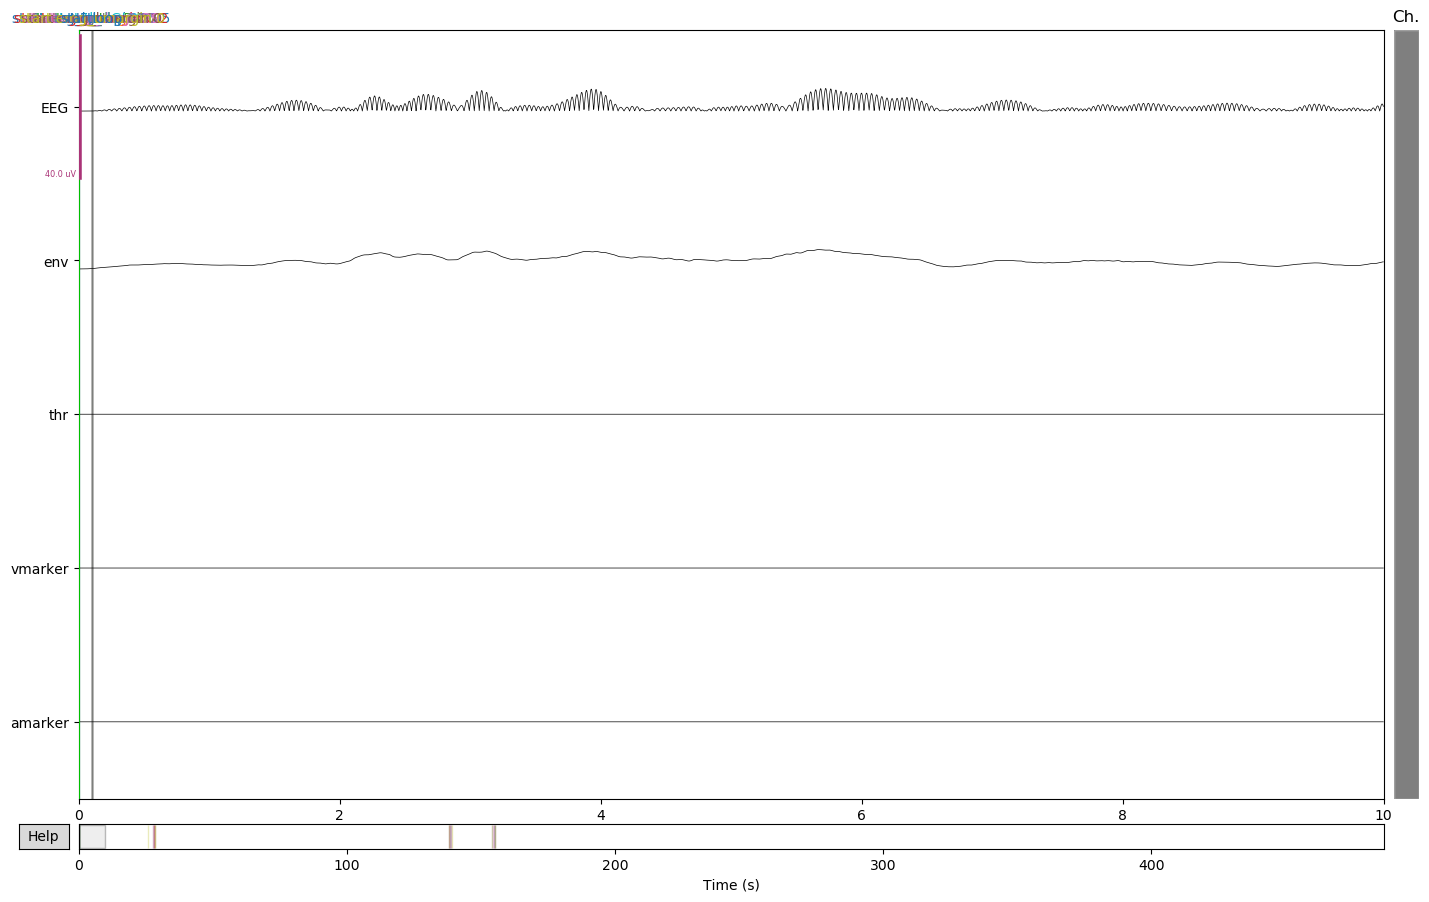

In [27]:
rtanalyzed_nftraining_eeg.plot();